<Figure size 640x480 with 0 Axes>

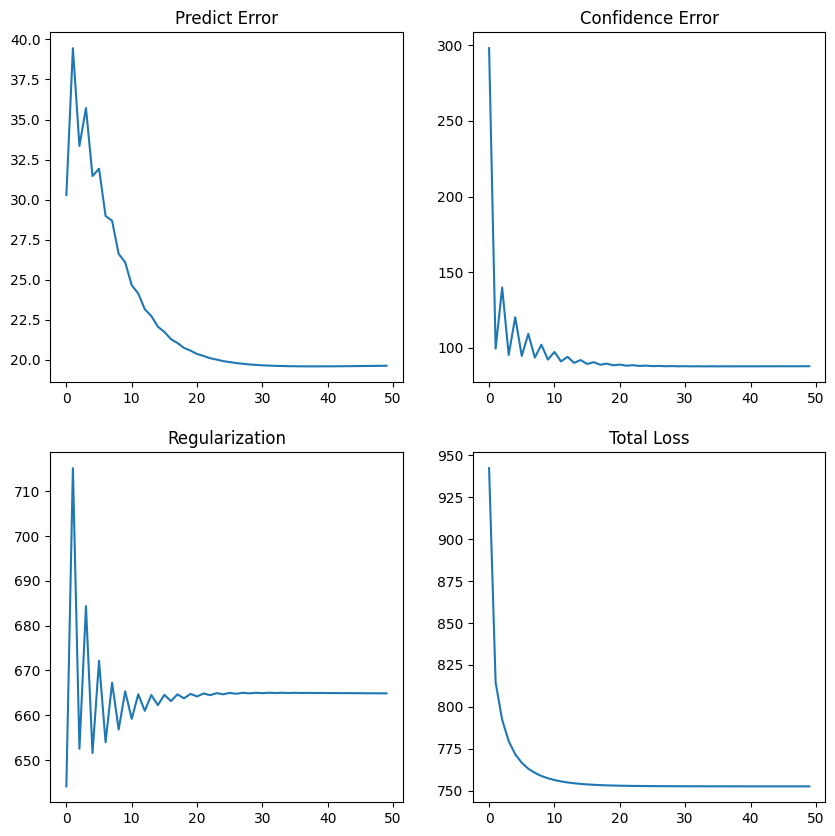

In [2]:
# Hyper Parameter Setting
r_lambda = 40
nf = 200
alpha = 40

import numpy as np


# sample rating matrix
R = np.array([[0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0],
              [0, 3, 4, 0, 3, 0, 0, 2, 2, 0, 0],
              [0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5],
              [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 0, 3, 0, 0, 0, 0, 4, 5, 0]])

nu = R.shape[0] #10
ni = R.shape[1] #11

# initialize X and Y with very small values
X = np.random.rand(nu, nf) * 0.01 #shape = (10, 200)
Y = np.random.rand(ni, nf) * 0.01 #shape = (11, 200)

P = np.copy(R)
P[P > 0] = 1
C = 1 + alpha * R #alpha = 40

# Define Loss Function
def loss_function(C, P, xTy, X, Y, r_lambda):
    predict_error = np.square(P - xTy)
    confidence_error = np.sum(C * predict_error)
    regularization = r_lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))
    total_loss = confidence_error + regularization
    return np.sum(predict_error), confidence_error, regularization, total_loss

# Define User Opimizer Function
def optimize_user(X, Y, C, P, nu, nf, r_lambda):
    # Y = number of Items, shape = (11, 200)
    yT = np.transpose(Y) #shape = (200, 11)
    for u in range(nu):
        Cu = np.diag(C[u]) #shape = (11, 11)
        yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y) #{(200, 11)*(11, 11)}*(11, 200) = (200, 200)
        lI = np.dot(r_lambda, np.identity(nf))
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)

# Define Item Opimizer Function
def optimize_item(X, Y, C, P, ni, nf, r_lambda):
    # X = number of users, shape = (10, 200)
    xT = np.transpose(X) #shape = (200, 10)
    for i in range(ni):
        Ci = np.diag(C[:, i]) #shape = (10, 10)
        xT_Ci_x = np.matmul(np.matmul(xT, Ci), X) #{(200, 11)*(11, 11)}*(11, 200) = (200, 200)
        lI = np.dot(r_lambda, np.identity(nf))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

# Run Learning
predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in range(50):
    if i%2 == 0:   
        optimize_user(X, Y, C, P, nu, nf, r_lambda)
        optimize_item(X, Y, C, P, ni, nf, r_lambda)
    else:
        optimize_item(X, Y, C, P, ni, nf, r_lambda)
        optimize_user(X, Y, C, P, nu, nf, r_lambda)
        
    predict = np.matmul(X, np.transpose(Y))
    predict_error, confidence_error, regularization, total_loss = loss_function(C, P, predict, X, Y, r_lambda)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)

# Make Result Graph
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()